In [1]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
def gen_X(size, dim, var):
    return np.random.normal(0, np.sqrt(var), [size, dim])
def gen_Z(x, size, dim, var):
    return x[:,:dim] + np.random.normal(0, np.sqrt(var), [size, dim])
def capacity(power, noise, dim):
    return dim * 0.5 * np.log2(1 + power / noise)

In [3]:
class Net(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear((x_dim + y_dim), 10),
            nn.ReLU(),
            nn.Linear(10, 1))

    def forward(self, x, y):
        batch_size = x.size(0)
        tiled_x = torch.cat([x, x, ], dim=0)
        idx = torch.randperm(batch_size)

        shuffled_y = y[idx]
        concat_y = torch.cat([y, shuffled_y], dim=0)
        inputs = torch.cat([tiled_x, concat_y], dim=1)
        logits = self.layers(inputs)

        pred_xy = logits[:batch_size]
        pred_x_y = logits[batch_size:]
        loss = - np.log2(np.exp(1)) * (torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y))))
        return loss

In [4]:
class Estimator():
    def __init__(self, x_dim, y_dim):
        self.net = Net(x_dim, y_dim)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.01)
        self.x_dim = x_dim
        self.y_dim = y_dim

    def backward(self, x, y):
        loss = self.net(x, y)
        self.net.zero_grad()
        loss.backward()
        self.optimizer.step()
        info = -loss.detach()
        return info

In [5]:
power = 3
noise = 0.5
n_epoch = 1000
batch_size = 10000
x_dim = 1
y_dim = 1
info_values = []

In [6]:
mi = capacity(power, noise, y_dim)
print('True MI:', mi)

True MI: 1.403677461028802


In [7]:
estimator = Estimator(x_dim, y_dim)
for epoch in tqdm(range(n_epoch)):
    x_sample = gen_X(batch_size, x_dim, power)
    z_sample = gen_Z(x_sample, batch_size, y_dim, noise)
    x_sample = torch.tensor(x_sample, dtype=torch.float32)
    z_sample = torch.tensor(z_sample, dtype=torch.float32)
    info = estimator.backward(x_sample, z_sample)
    info_values.append(info.item())

100%|██████████| 1000/1000 [00:01<00:00, 551.82it/s]


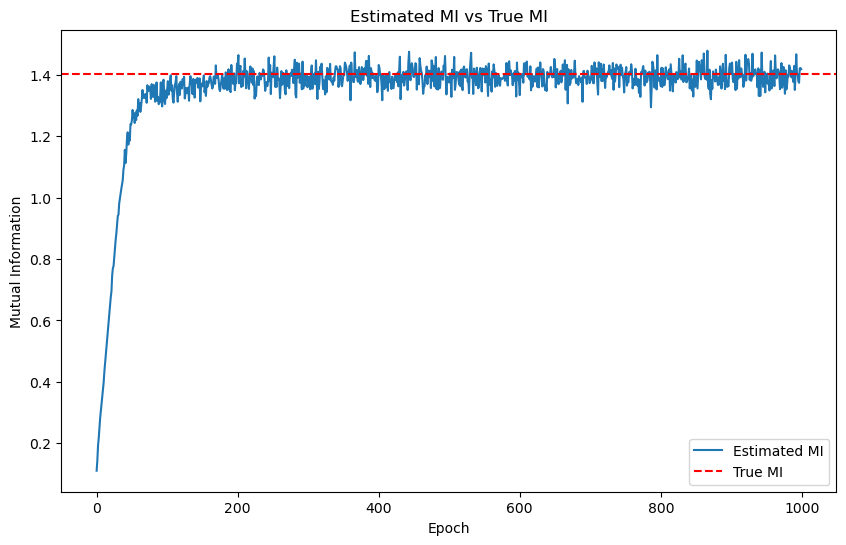

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(range(n_epoch), info_values, label='Estimated MI')
plt.axhline(y=mi, color='r', linestyle='--', label='True MI')
plt.title('Estimated MI vs True MI')
plt.xlabel('Epoch')
plt.ylabel('Mutual Information')
plt.legend()
plt.show()